In [ ]:
import os
import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from tqdm import tqdm

from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

from arch import arch_model  # Required for E-GARCH
import yfinance as yf


In [2]:
PROJECT_DIR = Path.cwd()
DATA_DIR = os.path.join(PROJECT_DIR, 'data')
OUT_DIR = os.path.join(PROJECT_DIR, 'output')
for d in [DATA_DIR, OUT_DIR]:
    os.makedirs(d, exist_ok=True)

In [ ]:
df = pd.read_csv('data/merged_features.csv', index_col=0, parse_dates=True)

In [4]:
vol = pd.read_csv('data/oxfordmanrealizedvolatilityindices.csv', index_col=0, parse_dates=True)

In [5]:
df

,Relative_Volume,True_Range_S&P,Momentum_1D_gold,Momentum_1D_oil,Momentum_1D_yield,Corr_SP_Gold,Corr_SP_Oil,Corr_SP_DGS10,True_Range_Oil,True_Range_Gold,...,Log_VIX_Change,Log_RV_Daily,Log_RV_Weekly,Log_RV_Monthly,Target_Log_RV,Kurtosis_60D,Momentum_1D_sp,Momentum_1W_sp,Momentum_1M_sp,RSI_14
Date,,,,,,,,,,,,,,,,,,,,,
2001-04-02,1.004645,32.000000,-0.008958,-0.031162,0.010091,-0.077436,0.147735,0.486520,0.920000,2.899994,...,0.085934,-5.544153,-4.487533,-4.254208,-4.108424,1.384399,-0.012540,-0.005934,-0.093311,38.830397
2001-04-03,1.117052,45.680054,0.004684,0.023176,-0.008065,-0.101200,0.052936,0.375447,0.790001,3.100006,...,0.106577,-4.108424,-4.411001,-4.249163,-3.957253,-0.000227,-0.034998,-0.066186,-0.113897,33.139865
2001-04-04,1.159867,25.510010,0.006211,0.034894,0.000000,-0.102632,0.056083,0.370781,1.110001,3.700012,...,-0.018899,-3.957253,-4.389214,-4.242246,-4.085195,0.046944,-0.002905,-0.044358,-0.117842,32.719272
2001-04-05,1.113960,48.219971,-0.001162,0.005149,0.008065,-0.090352,0.057346,0.346696,1.130001,1.399994,...,-0.129222,-4.085195,-4.374130,-4.242657,-3.902031,0.848875,0.042753,0.003036,-0.069394,44.174101
2001-04-06,1.029439,32.149902,0.007335,-0.007364,-0.018238,-0.106825,0.062777,0.366342,0.470001,2.400024,...,0.056806,-3.902031,-4.319411,-4.205430,-4.401230,0.689501,-0.020186,-0.027877,-0.095421,40.618111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-09,0.924728,15.710205,0.001854,0.006705,-0.008439,-0.057554,0.297631,0.293174,1.349998,12.600098,...,0.018195,-5.788097,-5.409578,-5.028135,-4.729817,1.085521,-0.001114,0.021951,0.042592,64.032937
2021-02-10,0.978463,46.560059,0.002884,0.005468,-0.025752,-0.050895,0.301848,0.296838,0.829998,15.799927,...,0.016507,-4.729817,-5.325359,-5.017457,-5.027483,1.103273,-0.000345,0.020597,0.027509,63.805239
2021-02-11,0.929678,35.600098,-0.008566,-0.007527,0.008658,-0.037798,0.285508,0.247044,0.869999,24.099976,...,-0.034231,-5.027483,-5.250134,-5.025805,-5.570071,1.386569,0.001661,0.011464,0.023693,64.460479


In [ ]:


def run_elasticnet_sliding_window_optimized(df, window_size=2000, refit_freq=30, test_start=2000):
    """
    Sliding Window ElasticNet forecasting.
    Hyperparameters (alpha, l1_ratio) AND coefficients are updated only every
    `refit_freq` days. Between refits, we use the last fitted model and
    preprocessing pipeline (winsorization + scaling) to generate forecasts.
    """
    
    # 1. PREPARE DATA
    data = df.dropna().copy()
    X = data.drop(columns=['Target_Log_RV'])
    y = data['Target_Log_RV']
    
    feature_names = X.columns
    
    # Convert to NumPy Arrays for faster slicing
    X_np = X.values
    y_np = y.values
    
    print(f"--- Starting ElasticNet Rolling Window (refit_freq = {refit_freq}) ---")
    
    # Setup storage lists
    predictions = []
    dates = []
    coef_history = []
    param_history = []
    
    # Objects that will be updated only at refit dates
    curr_alpha = 0.1
    curr_l1_ratio = 0.5
    model = None
    scaler = None
    lower_caps = None
    upper_caps = None
    last_coef_series = None
    
    # --- TIME TRACKING START ---
    start_time = time.time()
    # ---------------------------
    
    # 2. MAIN LOOP
    for i in tqdm(range(test_start, len(data))):
        
        # A. Define Sliding Window only when needed
        #    (we only need full training data at refit dates)
        is_refit_step = (i == test_start) or ((i - test_start) % refit_freq == 0)
        
        if is_refit_step:
            # -------------------------------
            # REFIT STEP: full pipeline update
            # -------------------------------
            X_train_np = X_np[i - window_size : i]
            y_train_np = y_np[i - window_size : i]
            X_next_day_np = X_np[i : i+1]
            
            # PREPROCESSING
            X_train_df = pd.DataFrame(X_train_np, columns=feature_names)
            X_next_day_df = pd.DataFrame(X_next_day_np, columns=feature_names)
            
            # 1) WINSORIZATION (compute caps on TRAIN only)
            lower_caps = X_train_df.quantile(0.005)
            upper_caps = X_train_df.quantile(0.995)
            
            X_train_clipped = X_train_df.clip(lower=lower_caps, upper=upper_caps, axis=1).values
            X_next_day_clipped = X_next_day_df.clip(lower=lower_caps, upper=upper_caps, axis=1).values
            
            # 2) STANDARDIZATION (fit scaler on TRAIN only)
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train_clipped)
            X_next_day_scaled = scaler.transform(X_next_day_clipped)
            
            # HYPERPARAMETER OPTIMIZATION via TimeSeries CV
            tscv = TimeSeriesSplit(n_splits=5)
            cv_model = ElasticNetCV(
                l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.99],
                alphas=100,
                cv=tscv,
                n_jobs=-1,
                max_iter=2000
            )
            cv_model.fit(X_train_scaled, y_train_np)
            
            curr_alpha = cv_model.alpha_
            curr_l1_ratio = cv_model.l1_ratio_
            
            param_history.append({
                'Date': data.index[i],
                'Alpha': curr_alpha,
                'L1_Ratio': curr_l1_ratio
            })
            
            # FINAL MODEL FIT on the *full* training window with chosen (alpha, l1_ratio)
            model = ElasticNet(alpha=curr_alpha,
                               l1_ratio=curr_l1_ratio,
                               max_iter=2000)
            model.fit(X_train_scaled, y_train_np)
            
            # Store coefficients for interpretability
            last_coef_series = pd.Series(model.coef_, index=feature_names)
            coef_history.append(last_coef_series)
            
            # Forecast for next day (already scaled/clipped above)
            pred_log_vol = model.predict(X_next_day_scaled)[0]
        
        else:
            
            # Only need the next-day features
            X_next_day_np = X_np[i : i+1]
            X_next_day_df = pd.DataFrame(X_next_day_np, columns=feature_names)
            
            # Apply the LAST winsorization caps
            X_next_day_clipped = X_next_day_df.clip(
                lower=lower_caps, upper=upper_caps, axis=1
            ).values
            
            # Apply the LAST scaler
            X_next_day_scaled = scaler.transform(X_next_day_clipped)
            
            # Predict with the LAST fitted model
            pred_log_vol = model.predict(X_next_day_scaled)[0]
            
            # Coefficients are the same as at the last refit
            coef_history.append(last_coef_series)
        
        # Store prediction and date
        predictions.append(pred_log_vol)
        dates.append(data.index[i])
    
    # 3. PROCESS RESULTS
    results = pd.DataFrame(index=dates)
    results['Pred_Log_Vol'] = predictions
    
    # Invert Transformation: Exp(Log) -> Volatility
    results['ElasticNet_Vol'] = np.exp(results['Pred_Log_Vol'])
    
    # Get True Target (Raw Volatility)
    true_log_targets = y.iloc[test_start:]
    results['True_Vol'] = np.exp(true_log_targets.values)
    
    # 4. METRICS
    y_true = results['True_Vol'].values
    y_pred = results['ElasticNet_Vol'].values

    # RMSE / MAE
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)

    # R2 vs MEAN (standard regression-style)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - y_true.mean()) ** 2)
    r2_mean = 1 - ss_res / ss_tot

    # R2 vs RANDOM WALK (Campbell–Thompson style)
    # benchmark: y_{t-1}
    y_lag = y_true[:-1]
    y_now = y_true[1:]
    y_pred_now = y_pred[1:]

    num = np.sum((y_now - y_pred_now) ** 2)
    den = np.sum((y_now - y_lag) ** 2)
    r2_rw = 1 - num / den

    print(f"\nRMSE (ElasticNet):        {rmse:.6f}")
    print(f"MAE  (ElasticNet):        {mae:.6f}")
    print(f"R2 (vs mean, ElasticNet): {r2_mean:.6f}")
    print(f"R2 (vs RW, ElasticNet):   {r2_rw:.6f}")
    
    # --- TIME TRACKING END ---
    end_time = time.time()
    elapsed_time = end_time - start_time
    # -------------------------

    # 5. PLOTTING & RETURN
    plt.figure(figsize=(14, 7))
    
    # Convert to % for display (0.01 -> 1.0%)
    plt.plot(results.index, results['True_Vol'] * 100,
             color='silver', linewidth=0.9, alpha = 1, label='Realised Daily Volatility')
    plt.plot(results.index, results['ElasticNet_Vol'] * 100,
             color='firebrick', linewidth=0.9, alpha = 0.8, label='ElasticNet Forecast')
    
    plt.title('ElasticNet Predictions vs Realised Daily Volatility',
              fontsize=14, fontweight='bold')
    plt.ylabel('Daily Volatility (%)', fontsize=12, fontweight='bold')
    
    # Format Axis
    ax = plt.gca()
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))
    ax.grid(True, color='#e0e0e0', linestyle='-', linewidth=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(0, 8) 
    plt.legend(frameon=True, fontsize=11, loc='upper left', framealpha=0.9)
    plt.tight_layout()
    
    # Save PDF
    try:
        save_path = os.path.join(OUT_DIR, 'elasticnet_forecast_results.pdf')
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
        print(f"Graph saved to: {save_path}")
    except NameError:
        print("Could not save PDF (OUT_DIR not defined).")
        
    plt.show()

    # Final result metrics structure
    final_metrics = {
        'RMSE': rmse,
        'MAE': mae,
        'R2_mean': r2_mean,
        'R2_RW': r2_rw,
        'Params': pd.DataFrame(param_history),
        'Coefficients': pd.DataFrame(coef_history, index=dates),
        'Time': elapsed_time
    }
    
    return results, final_metrics


--- Starting ElasticNet Rolling Window (refit_freq = 20) ---


100%|██████████| 2983/2983 [00:43<00:00, 68.94it/s]



RMSE (ElasticNet):        0.003361
MAE  (ElasticNet):        0.001868
R2 (vs mean, ElasticNet): 0.610273
R2 (vs RW, ElasticNet):   0.143377
Graph saved to: c:\Etudes\EPFL\2eme\MA3\Advanced data analysis (UNIL)\Capstone Project\Code\output\elasticnet_forecast_results.pdf


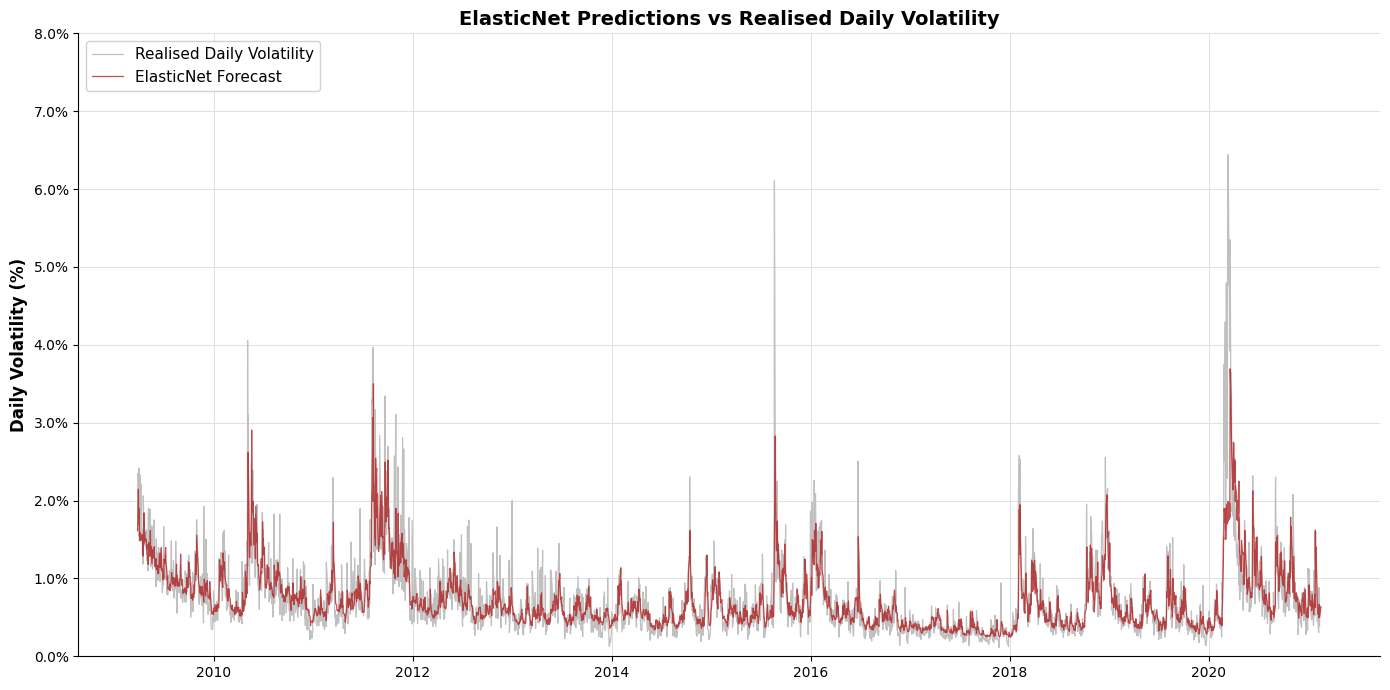

In [7]:
enet_results, enet_metrics = run_elasticnet_sliding_window_optimized(
    df, 
    window_size=2000, 
    refit_freq=20, 
    test_start=2000
)

In [8]:
#Save the results for multiple plotting:

enet_results.to_csv("results_elasticnet.csv")

In [10]:
enet_metrics

{'RMSE': np.float64(0.0033609289640102306),
 'MAE': 0.0018680425629385834,
 'R2_mean': np.float64(0.6102729924843071),
 'R2_RW': np.float64(0.14337704370349968),
 'Params':           Date     Alpha  L1_Ratio
 0   2009-03-27  0.017898      0.10
 1   2009-04-27  0.019362      0.10
 2   2009-05-26  0.002790      0.99
 3   2009-06-23  0.005541      0.50
 4   2009-07-22  0.004885      0.70
 ..         ...       ...       ...
 145 2020-10-15  0.054512      0.10
 146 2020-11-12  0.047717      0.10
 147 2020-12-11  0.038681      0.10
 148 2021-01-13  0.041523      0.10
 149 2021-02-11  0.063053      0.10
 
 [150 rows x 3 columns],
 'Coefficients':             Relative_Volume  True_Range_S&P  Momentum_1D_gold  \
 2009-03-27         0.034779        0.023515         -0.002996   
 2009-03-30         0.034779        0.023515         -0.002996   
 2009-03-31         0.034779        0.023515         -0.002996   
 2009-04-01         0.034779        0.023515         -0.002996   
 2009-04-02         0.0

FEATURE IMPORTANCE MAP

Top features by selection frequency:
                 SelectionFreq  MeanAbsCoef
Relative_Volume     100.000000     0.023895
Momentum_1W_sp      100.000000     0.022771
Log_RV_Daily        100.000000     0.068816
Log_RV_Weekly       100.000000     0.117211
Log_VIX_Change      100.000000     0.015738
Log_VIX             100.000000     0.233464
RSI_14              100.000000     0.033991
Momentum_1D_sp       93.865236     0.015656
Corr_SP_Gold         88.602078     0.014709
Corr_SP_DGS10        76.533691     0.005640
Graph saved to: c:\Etudes\EPFL\2eme\MA3\Advanced data analysis (UNIL)\Capstone Project\Code\output\elasticnet_features_importance.pdf


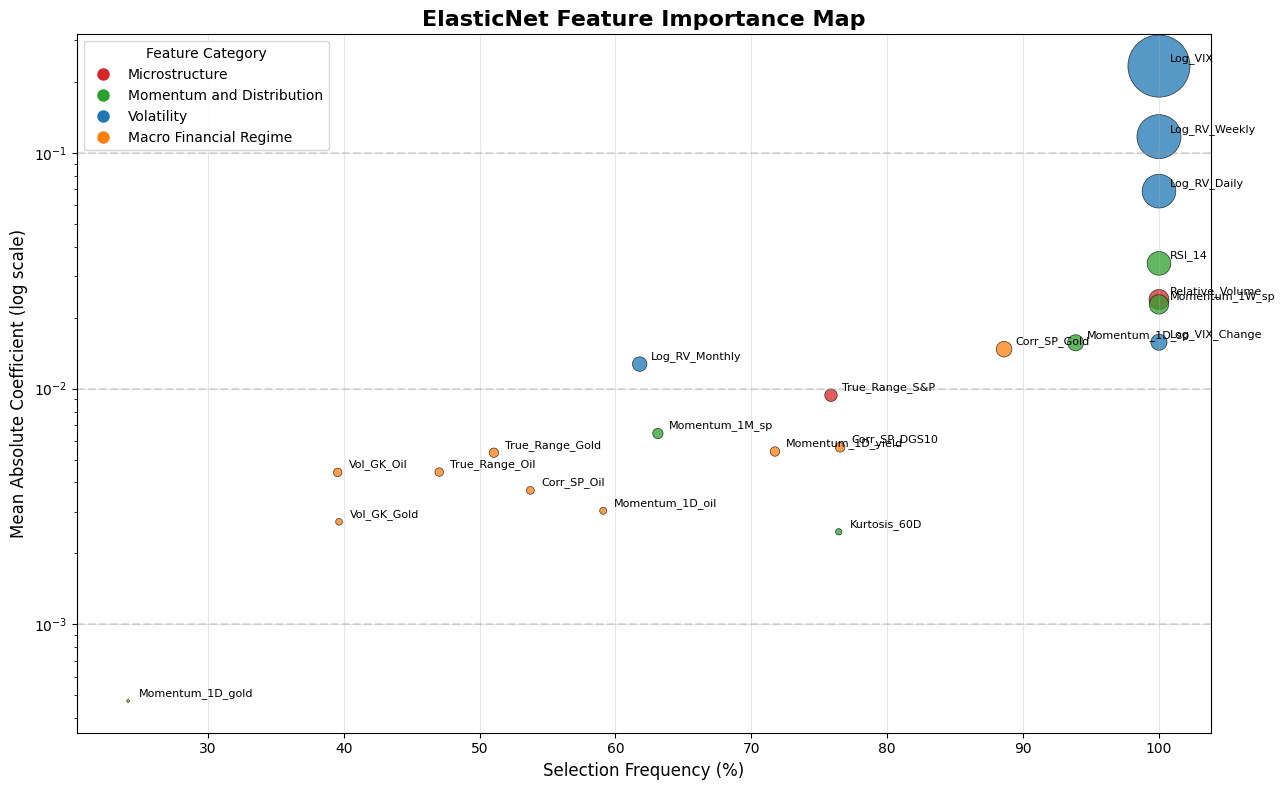

In [ ]:

df_coefficients = enet_metrics['Coefficients']


# coef_df: rows = dates, columns = features (from your ElasticNet rolling)
# Example: coef_df = final_metrics['Coefficients']

coefs = df_coefficients.copy()

# ---------- 1. Compute feature importance metrics ----------

# Selection frequency (% windows where β ≠ 0)
selection_freq = (coefs != 0).mean() * 100

# Mean absolute coefficient
mean_abs_coef = coefs.abs().mean()

# Combine metrics
importance_df = pd.DataFrame({
    "SelectionFreq": selection_freq,
    "MeanAbsCoef": mean_abs_coef
})

importance_df = importance_df.sort_values("SelectionFreq", ascending=False)

print("Top features by selection frequency:")
print(importance_df.head(10))


# ---------- 2. MANUAL FEATURE CLASSIFICATION ----------

feature_categories = {
    'Relative_Volume':      'Microstructure',
    'True_Range_S&P':       'Microstructure',

    'Momentum_1D_gold':     'Macro Financial Regime',
    'Momentum_1D_oil':      'Macro Financial Regime',
    'Momentum_1D_yield':    'Macro Financial Regime',
    'Corr_SP_Gold':         'Macro Financial Regime',
    'Corr_SP_Oil':          'Macro Financial Regime',
    'Corr_SP_DGS10':        'Macro Financial Regime',
    'True_Range_Oil':       'Macro Financial Regime',
    'True_Range_Gold':      'Macro Financial Regime',
    'Vol_GK_Oil':           'Macro Financial Regime',
    'Vol_GK_Gold':          'Macro Financial Regime',

    'Log_VIX':              'Volatility',
    'Log_VIX_Change':       'Volatility',
    'Log_RV_Daily':         'Volatility',
    'Log_RV_Weekly':        'Volatility',
    'Log_RV_Monthly':       'Volatility',
    'Target_Log_RV':        'Target',

    'Kurtosis_60D':         'Momentum and Distribution',
    'Momentum_1D_sp':       'Momentum and Distribution',
    'Momentum_1W_sp':       'Momentum and Distribution',
    'Momentum_1M_sp':       'Momentum and Distribution',
    'RSI_14':               'Momentum and Distribution',

    'EGARCH_Omega':         'EGARCH Feature',
    'EGARCH_Alpha':         'EGARCH Feature',
    'EGARCH_Beta':          'EGARCH Feature',
    'EGARCH_Gamma':         'EGARCH Feature',
    'EGARCH_LogVol':        'EGARCH Feature'
}

default_category = "Other"
importance_df["Category"] = [
    feature_categories.get(f, default_category) for f in importance_df.index
]

category_colors = {
    'Microstructure':              'tab:red',
    'Macro Financial Regime':                 'tab:orange',
    'Volatility':                  'tab:blue',
    'Momentum and Distribution':   'tab:green',
    'EGARCH Feature':              'tab:cyan',
    'Target':                      'black',
    'Other':                       'tab:gray'
}

importance_df["Color"] = importance_df["Category"].map(category_colors)


# ---------- 3. Bubble Size from MEAN ABSOLUTE COEFFICIENT ----------

# Normalize |β| to [0, 1] and scale
abs_coef = importance_df["MeanAbsCoef"]
bubble_size = 2000 * (abs_coef / abs_coef.max())  # 2000 controls overall size
importance_df["BubbleSize"] = bubble_size


# ---------- 4. 2D BUBBLE PLOT (log y-axis) ----------

plt.figure(figsize=(13, 8))

plt.scatter(
    importance_df["SelectionFreq"],
    importance_df["MeanAbsCoef"],
    s=importance_df["BubbleSize"],
    c=importance_df["Color"],
    alpha=0.75,
    edgecolors="black",
    linewidths=0.5
)

plt.yscale("log")
plt.ylabel("Mean Absolute Coefficient (log scale)", fontsize=12)
plt.xlabel("Selection Frequency (%)", fontsize=12)
plt.title("ElasticNet Feature Importance Map", fontsize=16, fontweight="bold")

# Horizontal reference lines (no text labels)
for v in [1e-1, 1e-2, 1e-3]:
    plt.axhline(v, color='gray', linestyle='--', alpha=0.25)

# Clean y-axis (no right labels)
ax = plt.gca()
ax.tick_params(axis='y', which='both', labelright=False)
ax.yaxis.set_ticks_position('left')

# Label only important features (high |β| or high selection)
for feat in importance_df.index:
    x = importance_df.loc[feat, "SelectionFreq"]
    y = importance_df.loc[feat, "MeanAbsCoef"]
    plt.text(x + 0.8, y * 1.05, feat, fontsize=8)

# Legend in top-left inside the plot
legend_elements = [
    plt.Line2D(
        [0], [0],
        marker='o', color='w', label=cat,
        markerfacecolor=category_colors.get(cat, 'tab:gray'),
        markersize=10
    )
    for cat in importance_df["Category"].unique()
]

plt.legend(
    handles=legend_elements,
    title="Feature Category",
    loc="upper left",
    frameon=True
)

plt.grid(alpha=0.3)
plt.tight_layout()

  # Save PDF
try:
    save_path = os.path.join(OUT_DIR, 'elasticnet_features_importance.pdf')
    plt.savefig(save_path, format='pdf', bbox_inches='tight')
    print(f"Graph saved to: {save_path}")
except NameError:
    print("Could not save PDF (OUT_DIR not defined).")


plt.show()


NOW ANALYZING THE DIRECTION OF EFFECT 

In [ ]:


coef_df = enet_metrics["Coefficients"]  # shape: (T, p)

# 1) Selected vs not selected
is_selected = coef_df != 0

# selection frequency in %
sel_freq = is_selected.mean(axis=0) * 100  # across time

# 2) Mean absolute coefficient (conditional on being selected)
mean_abs_coef = coef_df.where(is_selected).abs().mean(axis=0)

# 3) Mean signed coefficient (conditional on being selected)
mean_signed_coef = coef_df.where(is_selected).mean(axis=0)

# 4) Share of positive vs negative when selected
pos_share = (coef_df.where(is_selected) > 0).sum(axis=0) / is_selected.sum(axis=0)
neg_share = (coef_df.where(is_selected) < 0).sum(axis=0) / is_selected.sum(axis=0)

# Combine into one DataFrame
feat_stats = pd.DataFrame({
    "Selection_Freq_%": sel_freq,
    "Mean_Abs_Coeff": mean_abs_coef,
    "Mean_Signed_Coeff": mean_signed_coef,
    "Pos_Share": pos_share,
    "Neg_Share": neg_share,
})

feat_stats.sort_values("Selection_Freq_%", ascending=False, inplace=True)



,Selection_Freq_%,Mean_Abs_Coeff,Mean_Signed_Coeff,Pos_Share,Neg_Share
Relative_Volume,100.0,0.023895,0.023895,1.0,0.0
Momentum_1W_sp,100.0,0.022771,-0.022771,0.0,1.0
Log_RV_Daily,100.0,0.068816,0.068816,1.0,0.0
Log_RV_Weekly,100.0,0.117211,0.117211,1.0,0.0
Log_VIX_Change,100.0,0.015738,0.015738,1.0,0.0


In [12]:
feat_stats

,Selection_Freq_%,Mean_Abs_Coeff,Mean_Signed_Coeff,Pos_Share,Neg_Share
Relative_Volume,100.000000,0.023895,0.023895,1.000000,0.000000
Momentum_1W_sp,100.000000,0.022771,-0.022771,0.000000,1.000000
Log_RV_Daily,100.000000,0.068816,0.068816,1.000000,0.000000
Log_RV_Weekly,100.000000,0.117211,0.117211,1.000000,0.000000
Log_VIX_Change,100.000000,0.015738,0.015738,1.000000,0.000000
Log_VIX,100.000000,0.233464,0.233464,1.000000,0.000000
RSI_14,100.000000,0.033991,-0.033991,0.000000,1.000000
Momentum_1D_sp,93.865236,0.016680,-0.016624,0.007143,0.992857
Corr_SP_Gold,88.602078,0.016601,-0.010849,0.296254,0.703746
Corr_SP_DGS10,76.533691,0.007370,0.006275,0.833552,0.166448


<h1> ELASTICNET/EGARCH </h1>

In [26]:
#GET AN EXTENDED VERSION OF S&P DATA:

# 1. Setup
DATA_DIR = "data"
os.makedirs(DATA_DIR, exist_ok=True)

# Define Ticker and Dates
TICKER = '^GSPC'
START = "1999-01-02"
END = "2025-11-14"

# Define your custom filename here
CUSTOM_FILENAME = "SP500_expanded.csv" 


# 2. Download
df_exp = yf.download(TICKER, start=START, end=END, progress=False, auto_adjust=False)

if not df_exp.empty:
    # 3. Save with Specific Name
    # Reset index to make Date a column
    out = df_exp.reset_index()
    
    # Create full path using your custom name
    file_path = os.path.join(DATA_DIR, CUSTOM_FILENAME)
    
    out.to_csv(file_path, index=False)
    print(f"✅ Data saved successfully to: {file_path}")
else:
    print(f" No data found for {TICKER}")



✅ Data saved successfully to: data\SP500_expanded.csv


In [27]:
#read the csv sp500 expanded
df_500 = pd.read_csv('data/SP500_expanded.csv', parse_dates=True)

In [28]:
#keep only the Close collumn:
df_500 = df_500[['Date', 'Close']]

#get rid of the index line 0:
df_500 = df_500.iloc[1:]

#convert the Close collumn to float:
df_500['Close'] = df_500['Close'].astype(float)

#convert date to datetime format inplace:
df_500['Date'] = pd.to_datetime(df_500['Date'], format='%Y-%m-%d')

#compute the log returns with diff():
df_500['Log_Returns'] = np.log(df_500['Close']).diff()


#Drop the Close collumn inplace from df_500:
df_500.drop('Close', axis=1, inplace=True)

#Etase first row.
df_500 = df_500.iloc[1:]

#SSet index as date
df_egarch = df_500.set_index('Date')

In [29]:
#Check if there are nan in df_egarch:
df_egarch.isna().sum()

Log_Returns    0
dtype: int64

In [ ]:

#Download the oxfordmanrealizedvolatilityindices.csv file
var = pd.read_csv("data/oxfordmanrealizedvolatilityindices.csv")  

#Download the EGARCH_all__features.csv:
egarch = pd.read_csv("data/EGARCH_all_features.csv")

#Download the merged_features.csv:
merged = pd.read_csv("data/merged_features.csv")    


In [ ]:


def generate_egarch_features_3stage(df, refit_freq=20):
    """
    Implements the 3-Stage E-GARCH Feature Extraction with periodic refitting.
    
    - Stage 1 & 2: Expanding window until window length reaches MAX_WINDOW.
    - Stage 3: Fixed-size sliding window of MAX_WINDOW observations.
    
    EGARCH parameters are re-estimated every `refit_freq` steps,
    but one-step-ahead forecasts (and features) are produced for EVERY day.
    
    STRICT MODE: No error handling. Optimization failures will raise exceptions.
    """
    # 1. Data Setup
    data = df.dropna(subset=['Log_Returns']).copy()
    returns_series = data['Log_Returns'] * 100  # Scale for optimizer stability
    
    # Define Dates
    start_date = pd.Timestamp('2000-01-03')
    first_window_end = pd.Timestamp('2001-04-02')
    
    # Get integer locations (will raise if dates missing)
    start_idx = data.index.get_loc(start_date)
    current_end_idx = data.index.get_loc(first_window_end)
    
    results_list = []
    indices = []
    
    MAX_WINDOW = 2000
    
    # Total number of steps from first_window_end to end of sample
    total_steps = len(data) - current_end_idx
    
    print(f"--- Starting E-GARCH Feature Extraction with refit_freq = {refit_freq} ---")
    print(f"Start Date:       {start_date.date()}")
    print(f"First Window End: {first_window_end.date()}")
    
    # We'll store the latest fitted parameters here
    curr_params = None
    
    # 2. MAIN LOOP
    for step in tqdm(range(total_steps)):
        
        # A. Define current window length
        current_length = current_end_idx - start_idx + 1
        
        # B. Define the slice (3-stage logic unchanged)
        if current_length <= MAX_WINDOW:
            # Stage 1 & 2: Expanding window
            window_data = returns_series.iloc[start_idx : current_end_idx + 1]
        else:
            # Stage 3: Sliding window of fixed size MAX_WINDOW
            slide_start = current_end_idx - MAX_WINDOW + 1
            window_data = returns_series.iloc[slide_start : current_end_idx + 1]
        
        # C. Refit EGARCH only periodically
        # First step MUST refit, then every `refit_freq` steps
        if (step == 0) or (step % refit_freq == 0):
            base_model = arch_model(window_data, vol='EGarch', p=1, o=1, q=1,
                                    dist='Normal', rescale=False)
            res = base_model.fit(disp='off', options={'ftol': 1e-2})
            curr_params = res.params
        
        # D. Forecast with the current parameters (even on non-refit days)
        # Build a fresh model on the current window and fix parameters to curr_params
        temp_model = arch_model(window_data, vol='EGarch', p=1, o=1, q=1,
                                dist='Normal', rescale=False)
        forecast = temp_model.fix(curr_params).forecast(horizon=1, reindex=False)
        forecast_var = forecast.variance.iloc[-1, 0]
        
        # E. Store Results (associate with last date in window)
        date_label = data.index[current_end_idx]
        
        results_list.append({
            'EGARCH_Omega': curr_params['omega'],
            'EGARCH_Alpha': curr_params['alpha[1]'],
            'EGARCH_Beta':  curr_params['beta[1]'],
            'EGARCH_Gamma': curr_params['gamma[1]'],
            # variance was on scaled returns (x100), so divide by 100^2 = 10000, then sqrt+log
            'EGARCH_LogVol': np.log(np.sqrt(forecast_var / 10000.0))
        })
        indices.append(date_label)
        
        # Move forward one day
        current_end_idx += 1
        
        if current_end_idx >= len(data):
            break

    # 3. Compile DataFrame
    df_results = pd.DataFrame(results_list, index=indices)
    
    print("\nExtraction Complete.")
    print(f"Generated {len(df_results)} rows of E-GARCH features.")
    
    return df_results


In [31]:
df_egarch_features = generate_egarch_features_3stage(df_egarch)

--- Starting E-GARCH Feature Extraction with refit_freq = 20 ---
Start Date:       2000-01-03
First Window End: 2001-04-02


100%|█████████▉| 6192/6193 [00:15<00:00, 410.46it/s]


Extraction Complete.
Generated 6193 rows of E-GARCH features.


In [32]:
df_egarch_features

,EGARCH_Omega,EGARCH_Alpha,EGARCH_Beta,EGARCH_Gamma,EGARCH_LogVol
2001-04-02,0.030618,0.122727,0.958482,-0.242994,-3.958569
2001-04-03,0.030618,0.122727,0.958482,-0.242994,-3.699541
2001-04-04,0.030618,0.122727,0.958482,-0.242994,-3.761442
2001-04-05,0.030618,0.122727,0.958482,-0.242994,-3.944941
2001-04-06,0.030618,0.122727,0.958482,-0.242994,-3.830768
...,...,...,...,...,...
2025-11-07,-0.001448,0.183910,0.978825,-0.122777,-4.698021
2025-11-10,-0.001448,0.183910,0.978825,-0.122777,-4.721926
2025-11-11,-0.001448,0.183910,0.978825,-0.122777,-4.789537
2025-11-12,-0.001448,0.183910,0.978825,-0.122777,-4.854625


In [33]:
df_all_features = df.join(df_egarch_features, how='inner')


In [34]:
df_all_features

,Relative_Volume,True_Range_S&P,Momentum_1D_gold,Momentum_1D_oil,Momentum_1D_yield,Corr_SP_Gold,Corr_SP_Oil,Corr_SP_DGS10,True_Range_Oil,True_Range_Gold,...,Kurtosis_60D,Momentum_1D_sp,Momentum_1W_sp,Momentum_1M_sp,RSI_14,EGARCH_Omega,EGARCH_Alpha,EGARCH_Beta,EGARCH_Gamma,EGARCH_LogVol
2001-04-02,1.004645,32.000000,-0.008958,-0.031162,0.010091,-0.077436,0.147735,0.486520,0.920000,2.899994,...,1.384399,-0.012540,-0.005934,-0.093311,38.830397,0.030618,0.122727,0.958482,-0.242994,-3.958569
2001-04-03,1.117052,45.680054,0.004684,0.023176,-0.008065,-0.101200,0.052936,0.375447,0.790001,3.100006,...,-0.000227,-0.034998,-0.066186,-0.113897,33.139865,0.030618,0.122727,0.958482,-0.242994,-3.699541
2001-04-04,1.159867,25.510010,0.006211,0.034894,0.000000,-0.102632,0.056083,0.370781,1.110001,3.700012,...,0.046944,-0.002905,-0.044358,-0.117842,32.719272,0.030618,0.122727,0.958482,-0.242994,-3.761442
2001-04-05,1.113960,48.219971,-0.001162,0.005149,0.008065,-0.090352,0.057346,0.346696,1.130001,1.399994,...,0.848875,0.042753,0.003036,-0.069394,44.174101,0.030618,0.122727,0.958482,-0.242994,-3.944941
2001-04-06,1.029439,32.149902,0.007335,-0.007364,-0.018238,-0.106825,0.062777,0.366342,0.470001,2.400024,...,0.689501,-0.020186,-0.027877,-0.095421,40.618111,0.030618,0.122727,0.958482,-0.242994,-3.830768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-09,0.924728,15.710205,0.001854,0.006705,-0.008439,-0.057554,0.297631,0.293174,1.349998,12.600098,...,1.085521,-0.001114,0.021951,0.042592,64.032937,-0.020061,0.314130,0.933672,-0.169477,-4.808015
2021-02-10,0.978463,46.560059,0.002884,0.005468,-0.025752,-0.050895,0.301848,0.296838,0.829998,15.799927,...,1.103273,-0.000345,0.020597,0.027509,63.805239,-0.020061,0.314130,0.933672,-0.169477,-4.905017
2021-02-11,0.929678,35.600098,-0.008566,-0.007527,0.008658,-0.037798,0.285508,0.247044,0.869999,24.099976,...,1.386569,0.001661,0.011464,0.023693,64.460479,-0.020061,0.314130,0.933672,-0.169477,-5.009099
2021-02-12,0.839013,31.449951,-0.001810,0.020900,0.033902,-0.055574,0.354791,0.250075,2.410000,18.300049,...,1.556370,0.004700,0.012274,0.034554,66.324053,-0.020061,0.314130,0.933672,-0.169477,-5.072110


In [35]:
# Save the final dataframe with all features to CSV
df_all_features.to_csv(os.path.join(DATA_DIR, "EGARCH_all_features.csv"), index=True)   


In [3]:
#Once twe downloaded the data we can directly upload the full dataset with all features, including the EGARCH ones:

df_all_features = pd.read_csv('data/EGARCH_all_features.csv', index_col=0, parse_dates=True)


WE RUN THE MODEL WITH OURAUGUEMENTED SET OF FEATURES:

In [4]:


def run_elasticnet_sliding_window_optimized(df, window_size=2000, refit_freq=30, test_start=2000):
    """
    Sliding Window ElasticNet forecasting.
    Hyperparameters (alpha, l1_ratio) AND coefficients are updated only every
    `refit_freq` days. Between refits, we use the last fitted model and
    preprocessing pipeline (winsorization + scaling) to generate forecasts.
    """
    
    # 1. PREPARE DATA
    data = df.dropna().copy()
    X = data.drop(columns=['Target_Log_RV'])
    y = data['Target_Log_RV']
    
    feature_names = X.columns
    
    # Convert to NumPy Arrays for faster slicing
    X_np = X.values
    y_np = y.values
    
    print(f"--- Starting ElasticNet Rolling Window (refit_freq = {refit_freq}) ---")
    
    # Setup storage lists
    predictions = []
    dates = []
    coef_history = []
    param_history = []
    
    # Objects that will be updated only at refit dates
    curr_alpha = 0.1
    curr_l1_ratio = 0.5
    model = None
    scaler = None
    lower_caps = None
    upper_caps = None
    last_coef_series = None
    
    # --- TIME TRACKING START ---
    start_time = time.time()
    # ---------------------------
    
    # 2. MAIN LOOP
    for i in tqdm(range(test_start, len(data))):
        
        # A. Define Sliding Window only when needed
        #    (we only need full training data at refit dates)
        is_refit_step = (i == test_start) or ((i - test_start) % refit_freq == 0)
        
        if is_refit_step:
            # -------------------------------
            # REFIT STEP: full pipeline update
            # -------------------------------
            X_train_np = X_np[i - window_size : i]
            y_train_np = y_np[i - window_size : i]
            X_next_day_np = X_np[i : i+1]
            
            # PREPROCESSING
            X_train_df = pd.DataFrame(X_train_np, columns=feature_names)
            X_next_day_df = pd.DataFrame(X_next_day_np, columns=feature_names)
            
            # 1) WINSORIZATION (compute caps on TRAIN only)
            lower_caps = X_train_df.quantile(0.005)
            upper_caps = X_train_df.quantile(0.995)
            
            X_train_clipped = X_train_df.clip(lower=lower_caps, upper=upper_caps, axis=1).values
            X_next_day_clipped = X_next_day_df.clip(lower=lower_caps, upper=upper_caps, axis=1).values
            
            # 2) STANDARDIZATION (fit scaler on TRAIN only)
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train_clipped)
            X_next_day_scaled = scaler.transform(X_next_day_clipped)
            
            # HYPERPARAMETER OPTIMIZATION via TimeSeries CV
            tscv = TimeSeriesSplit(n_splits=5)
            cv_model = ElasticNetCV(
                l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.99],
                alphas=100,
                cv=tscv,
                n_jobs=-1,
                max_iter=2000
            )
            cv_model.fit(X_train_scaled, y_train_np)
            
            curr_alpha = cv_model.alpha_
            curr_l1_ratio = cv_model.l1_ratio_
            
            param_history.append({
                'Date': data.index[i],
                'Alpha': curr_alpha,
                'L1_Ratio': curr_l1_ratio
            })
            
            # FINAL MODEL FIT on the *full* training window with chosen (alpha, l1_ratio)
            model = ElasticNet(alpha=curr_alpha,
                               l1_ratio=curr_l1_ratio,
                               max_iter=2000)
            model.fit(X_train_scaled, y_train_np)
            
            # Store coefficients for interpretability
            last_coef_series = pd.Series(model.coef_, index=feature_names)
            coef_history.append(last_coef_series)
            
            # Forecast for next day (already scaled/clipped above)
            pred_log_vol = model.predict(X_next_day_scaled)[0]
        
        else:
            # -------------------------------
            # NO REFIT: reuse last model + preprocessing
            # -------------------------------
            # Only need the next-day features
            X_next_day_np = X_np[i : i+1]
            X_next_day_df = pd.DataFrame(X_next_day_np, columns=feature_names)
            
            # Apply the LAST winsorization caps
            X_next_day_clipped = X_next_day_df.clip(
                lower=lower_caps, upper=upper_caps, axis=1
            ).values
            
            # Apply the LAST scaler
            X_next_day_scaled = scaler.transform(X_next_day_clipped)
            
            # Predict with the LAST fitted model
            pred_log_vol = model.predict(X_next_day_scaled)[0]
            
            # Coefficients are the same as at the last refit
            coef_history.append(last_coef_series)
        
        # Store prediction and date
        predictions.append(pred_log_vol)
        dates.append(data.index[i])
    
    # 3. PROCESS RESULTS
    results = pd.DataFrame(index=dates)
    results['Pred_Log_Vol'] = predictions
    
    # Invert Transformation: Exp(Log) -> Volatility
    results['ElasticNet_Vol'] = np.exp(results['Pred_Log_Vol'])
    
    # Get True Target (Raw Volatility)
    true_log_targets = y.iloc[test_start:]
    results['True_Vol'] = np.exp(true_log_targets.values)
    
    # 4. METRICS
    y_true = results['True_Vol'].values
    y_pred = results['ElasticNet_Vol'].values

    # RMSE / MAE
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)

    # R2 vs MEAN (standard regression-style)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - y_true.mean()) ** 2)
    r2_mean = 1 - ss_res / ss_tot

    # R2 vs RANDOM WALK (Campbell–Thompson style)
    # benchmark: y_{t-1}
    y_lag = y_true[:-1]
    y_now = y_true[1:]
    y_pred_now = y_pred[1:]

    num = np.sum((y_now - y_pred_now) ** 2)
    den = np.sum((y_now - y_lag) ** 2)
    r2_rw = 1 - num / den

    print(f"\nRMSE (ElasticNet):        {rmse:.6f}")
    print(f"MAE  (ElasticNet):        {mae:.6f}")
    print(f"R2 (vs mean, ElasticNet): {r2_mean:.6f}")
    print(f"R2 (vs RW, ElasticNet):   {r2_rw:.6f}")
    
    # --- TIME TRACKING END ---
    end_time = time.time()
    elapsed_time = end_time - start_time
    # -------------------------

    # 5. PLOTTING & RETURN
    plt.figure(figsize=(14, 7))
    
    # Convert to % for display (0.01 -> 1.0%)
    plt.plot(results.index, results['True_Vol'] * 100,
             color='silver', linewidth=0.9, alpha = 1, label='Realised Daily Volatility')
    plt.plot(results.index, results['ElasticNet_Vol'] * 100,
             color='firebrick', linewidth=0.9, alpha = 0.8, label='ElasticNet Forecast')
    
    plt.title('ElasticNet Predictions vs Realised Daily Volatility',
              fontsize=14, fontweight='bold')
    plt.ylabel('Daily Volatility (%)', fontsize=12, fontweight='bold')
    
    # Format Axis
    ax = plt.gca()
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))
    ax.grid(True, color='#e0e0e0', linestyle='-', linewidth=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(0, 8) 
    plt.legend(frameon=True, fontsize=11, loc='upper left', framealpha=0.9)
    plt.tight_layout()
    
    # Save PDF
    try:
        save_path = os.path.join(OUT_DIR, 'elasticnet_EGARCH_forecast_results.pdf')
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
        print(f"Graph saved to: {save_path}")
    except NameError:
        print("Could not save PDF (OUT_DIR not defined).")
        
    plt.show()

    # Final result metrics structure
    final_metrics = {
        'RMSE': rmse,
        'MAE': mae,
        'R2_mean': r2_mean,
        'R2_RW': r2_rw,
        'Params': pd.DataFrame(param_history),
        'Coefficients': pd.DataFrame(coef_history, index=dates),
        'Time': elapsed_time
    }
    
    return results, final_metrics


--- Starting ElasticNet Rolling Window (refit_freq = 20) ---


100%|██████████| 2983/2983 [01:05<00:00, 45.21it/s]



RMSE (ElasticNet):        0.003380
MAE  (ElasticNet):        0.001861
R2 (vs mean, ElasticNet): 0.605794
R2 (vs RW, ElasticNet):   0.133212
Graph saved to: c:\Etudes\EPFL\2eme\MA3\Advanced data analysis (UNIL)\Capstone Project\Code\output\elasticnet_EGARCH_forecast_results.pdf


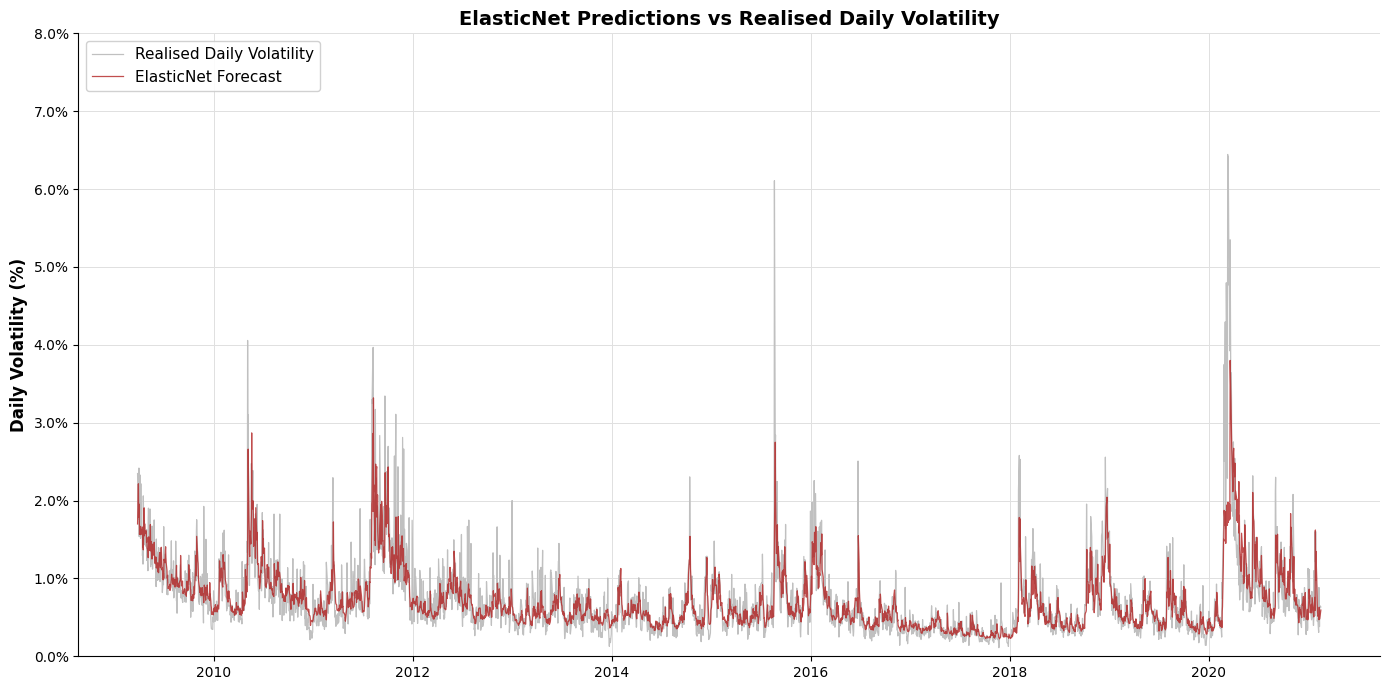

: 

In [ ]:
# Run the model
enet_results, enet_metrics = run_elasticnet_sliding_window_optimized(
    df_all_features, 
    window_size=2000, 
    refit_freq=20, 
    test_start=2000
)